In [40]:
import sys
from pathlib import Path

parent = str(Path().resolve().parent)
if parent not in sys.path:
    sys.path.insert(0, parent)

In [50]:
import ast
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from matplotlib.patches import Patch

In [51]:
with open("../data/wip/groups_graph.pkl", "rb") as f:
    G = pickle.load(f)

In [52]:
G_components = nx.connected_components(G)
G_largest_component = max(G_components, key=len)
G_giant = G.subgraph(G_largest_component)

In [53]:
df_groups = pd.read_csv("../data/wip/groups_wMembers_Text_Genres.csv")

genres_dict = dict(zip(df_groups["title"], df_groups["genres"]))

nx.set_node_attributes(G, genres_dict, name="genre")

/tmp/ipykernel_20000/1401610593.py:58: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



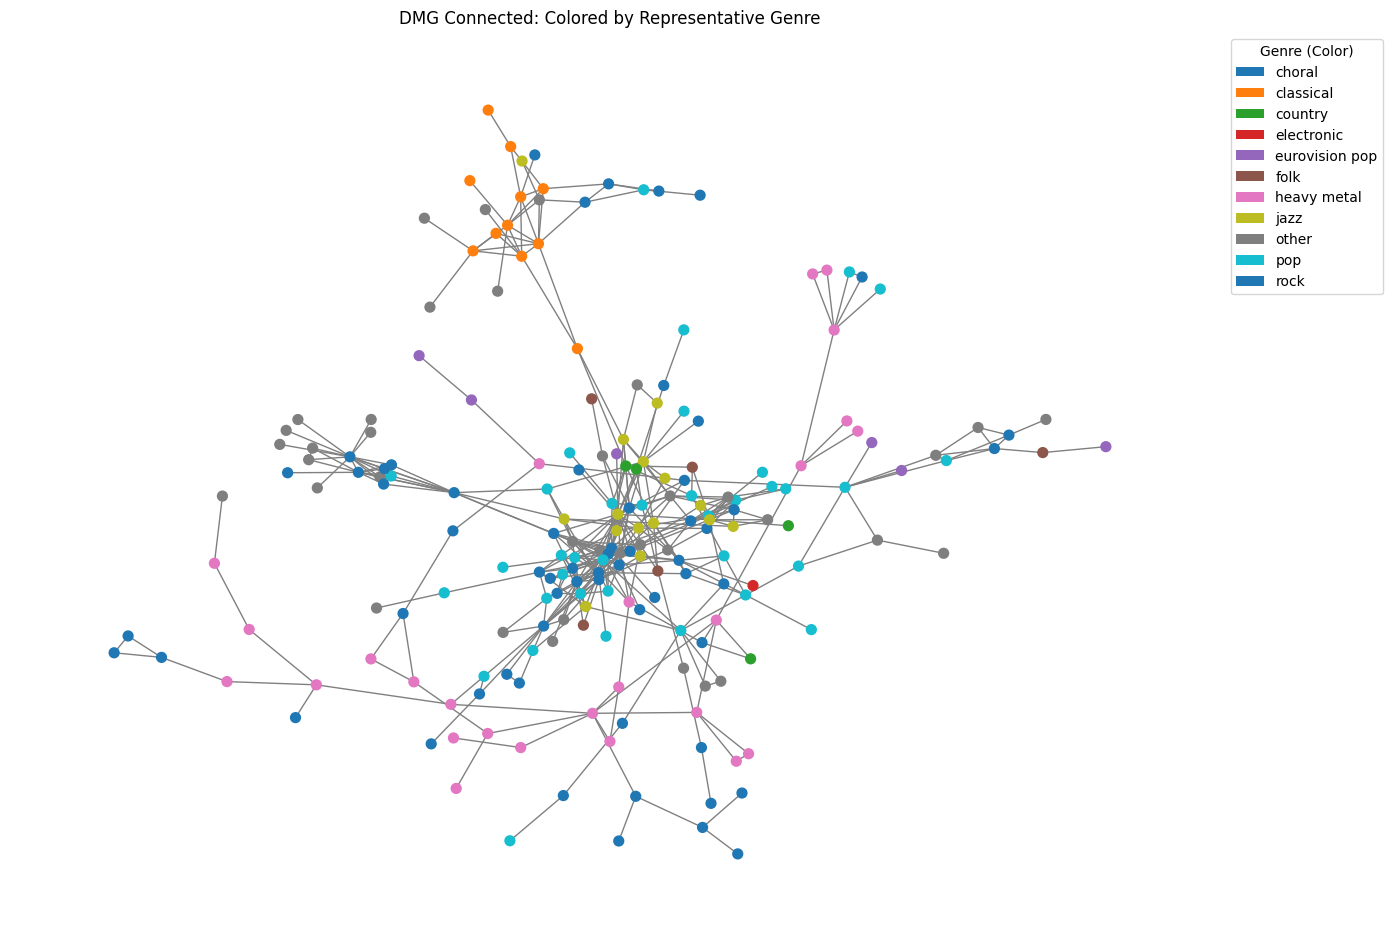

In [62]:
groupsG = G.copy()
groupsG.remove_nodes_from(list(nx.isolates(groupsG)))


def plotNetwork_color(G, title):
    #Genre hierarchy
    hierarchy = ["eurovision pop", "jazz", "choral", "classical", "heavy metal", "country", "electronic", "folk" , "pop", "rock"]
    # the hierarchy is defined in a way that the most common genres pop and rock are at the end of the list

    def pick_genre(genres_raw):
        if isinstance(genres_raw, str):
            try:
                genres = ast.literal_eval(genres_raw)
            except (ValueError, SyntaxError):
                genres = []
        else:
            genres = genres_raw or []

        genres_lower = [g.lower().strip() for g in genres]

        for genre in hierarchy:
            if genre in genres_lower:
                return genre
        return "other"


    genre_map = {node: pick_genre(G.nodes[node].get("genre")) for node in G.nodes()}


    unique_genres = sorted(set(genre_map.values()))

    color_map = {genre: plt.cm.tab10(i % 10) for i, genre in enumerate(unique_genres)}

    #NOTE: is the right genre swapped??
    color_map["other"], color_map["jazz"] = color_map["jazz"], color_map["other"]

    node_colors = [color_map[genre_map[node]] for node in G.nodes()]


    # Plot the graph
    pos = nx.spring_layout(G, k= 0.12, seed=43)
    plt.figure(figsize=(12, 9))

    nx.draw(
        G,
        pos,
        node_color=node_colors,
        with_labels=False,
        node_size=50,
        edge_color='gray'
    )

    # Create a legend as a table
    legend_elements = [Patch(facecolor=color_map[genre], label=genre) for genre in unique_genres]
    plt.legend(handles=legend_elements, title="Genre (Color)", loc="upper right", bbox_to_anchor=(1.15, 1.0))

    plt.title(title)
    plt.tight_layout()
    plt.savefig(title + ".svg")
    plt.show()

plotNetwork_color(groupsG, "DMG Connected: Colored by Representative Genre")

## Interactive graph HTML

In [63]:
import plotly.express as px
import plotly.graph_objects as go

In [64]:
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

hierarchy = [
    "eurovision pop", "jazz", "choral", "classical",
    "heavy metal", "country", "electronic", "folk",
    "pop", "rock"
]

In [65]:
def pick_genre(raw):
    # parse strings like "['pop','rock']" into a list
    if isinstance(raw, str):
        try:
            choices = ast.literal_eval(raw)
        except Exception:
            choices = []
    else:
        choices = raw or []
    lower = [g.lower().strip() for g in choices]
    for h in hierarchy:
        if h in lower:
            return h
    return "other"


In [66]:
genre_map = {n: pick_genre(G.nodes[n].get("genre")) for n in G.nodes()}
unique_genres = sorted(set(genre_map.values()))

# assign a consistent color to each genre via Plotly's default qualitative palette
palette = px.colors.qualitative.Plotly
color_map = {
    genre: palette[i % len(palette)]
    for i, genre in enumerate(unique_genres)
}
# swap jazz and other if you want to match your old Matplotlib tweak
color_map["other"], color_map["jazz"] = color_map["jazz"], color_map["other"]

In [67]:
pos = nx.spring_layout(G, seed=43, k=0.12)

edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    mode="lines",
    line=dict(color="lightgray", width=0.5),
    hoverinfo="none"
)

node_x, node_y, node_color, node_text = [], [], [], []
for n in G.nodes():
    x, y = pos[n]
    node_x.append(x)
    node_y.append(y)
    genre = genre_map[n]
    node_color.append(color_map[genre])
    degree = G.degree(n)
    node_text.append(f"<b>{n}</b><br>Genre: {genre}<br>Degree: {degree}")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode="markers",
    marker=dict(
        size=8,
        color=node_color,
        line=dict(width=0)
    ),
    text=node_text,
    hoverinfo="text"
)

In [58]:
legend_traces = []
for genre, col in color_map.items():
    legend_traces.append(
        go.Scatter(
            x=[None], y=[None],
            mode="markers",
            marker=dict(size=10, color=col),
            legendgroup=genre,
            showlegend=True,
            name=genre
        )
    )

# --- Compose figure and write out as HTML ---
fig = go.Figure(
    data=[edge_trace, node_trace] + legend_traces,
    layout=go.Layout(
        title="Interactive Bipartite Network Colored by Genre",
        showlegend=True,
        legend=dict(title="Genre"),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        margin=dict(l=20, r=20, t=40, b=20),
        hovermode="closest"
    )
)

fig.write_html("network_musicals.html", include_plotlyjs="cdn")

▶ network_genre_colored.html written — open it in your browser!
